#### Problem: Time Series Anomaly Detection 

Technique: LSTM Autoencoders 

Language: Python

Library: Keras

Source: https://www.curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/

Data at GitHub: https://github.com/curiousily/Deep-Learning-For-Hackers

Here I provide some additional explanation that will be helpful to understand Anomaly detection using LSTM-based Aoto Encoder.

In [1]:
!nvidia-smi

Wed Jun 10 09:59:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 445.75       Driver Version: 445.75       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   36C    P8     6W /  N/A |     92MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
#!pip install gdown

In [5]:
#!pip install tensorflow-gpu

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

#### Dataset: S&P 500 Index Data

The S&P 500, or just the S&P, is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. It is one of the most commonly followed equity indices, and many consider it to be one of the best representations of the U.S. stock market. -Wikipedia

In [8]:
#!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

In [9]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [14]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


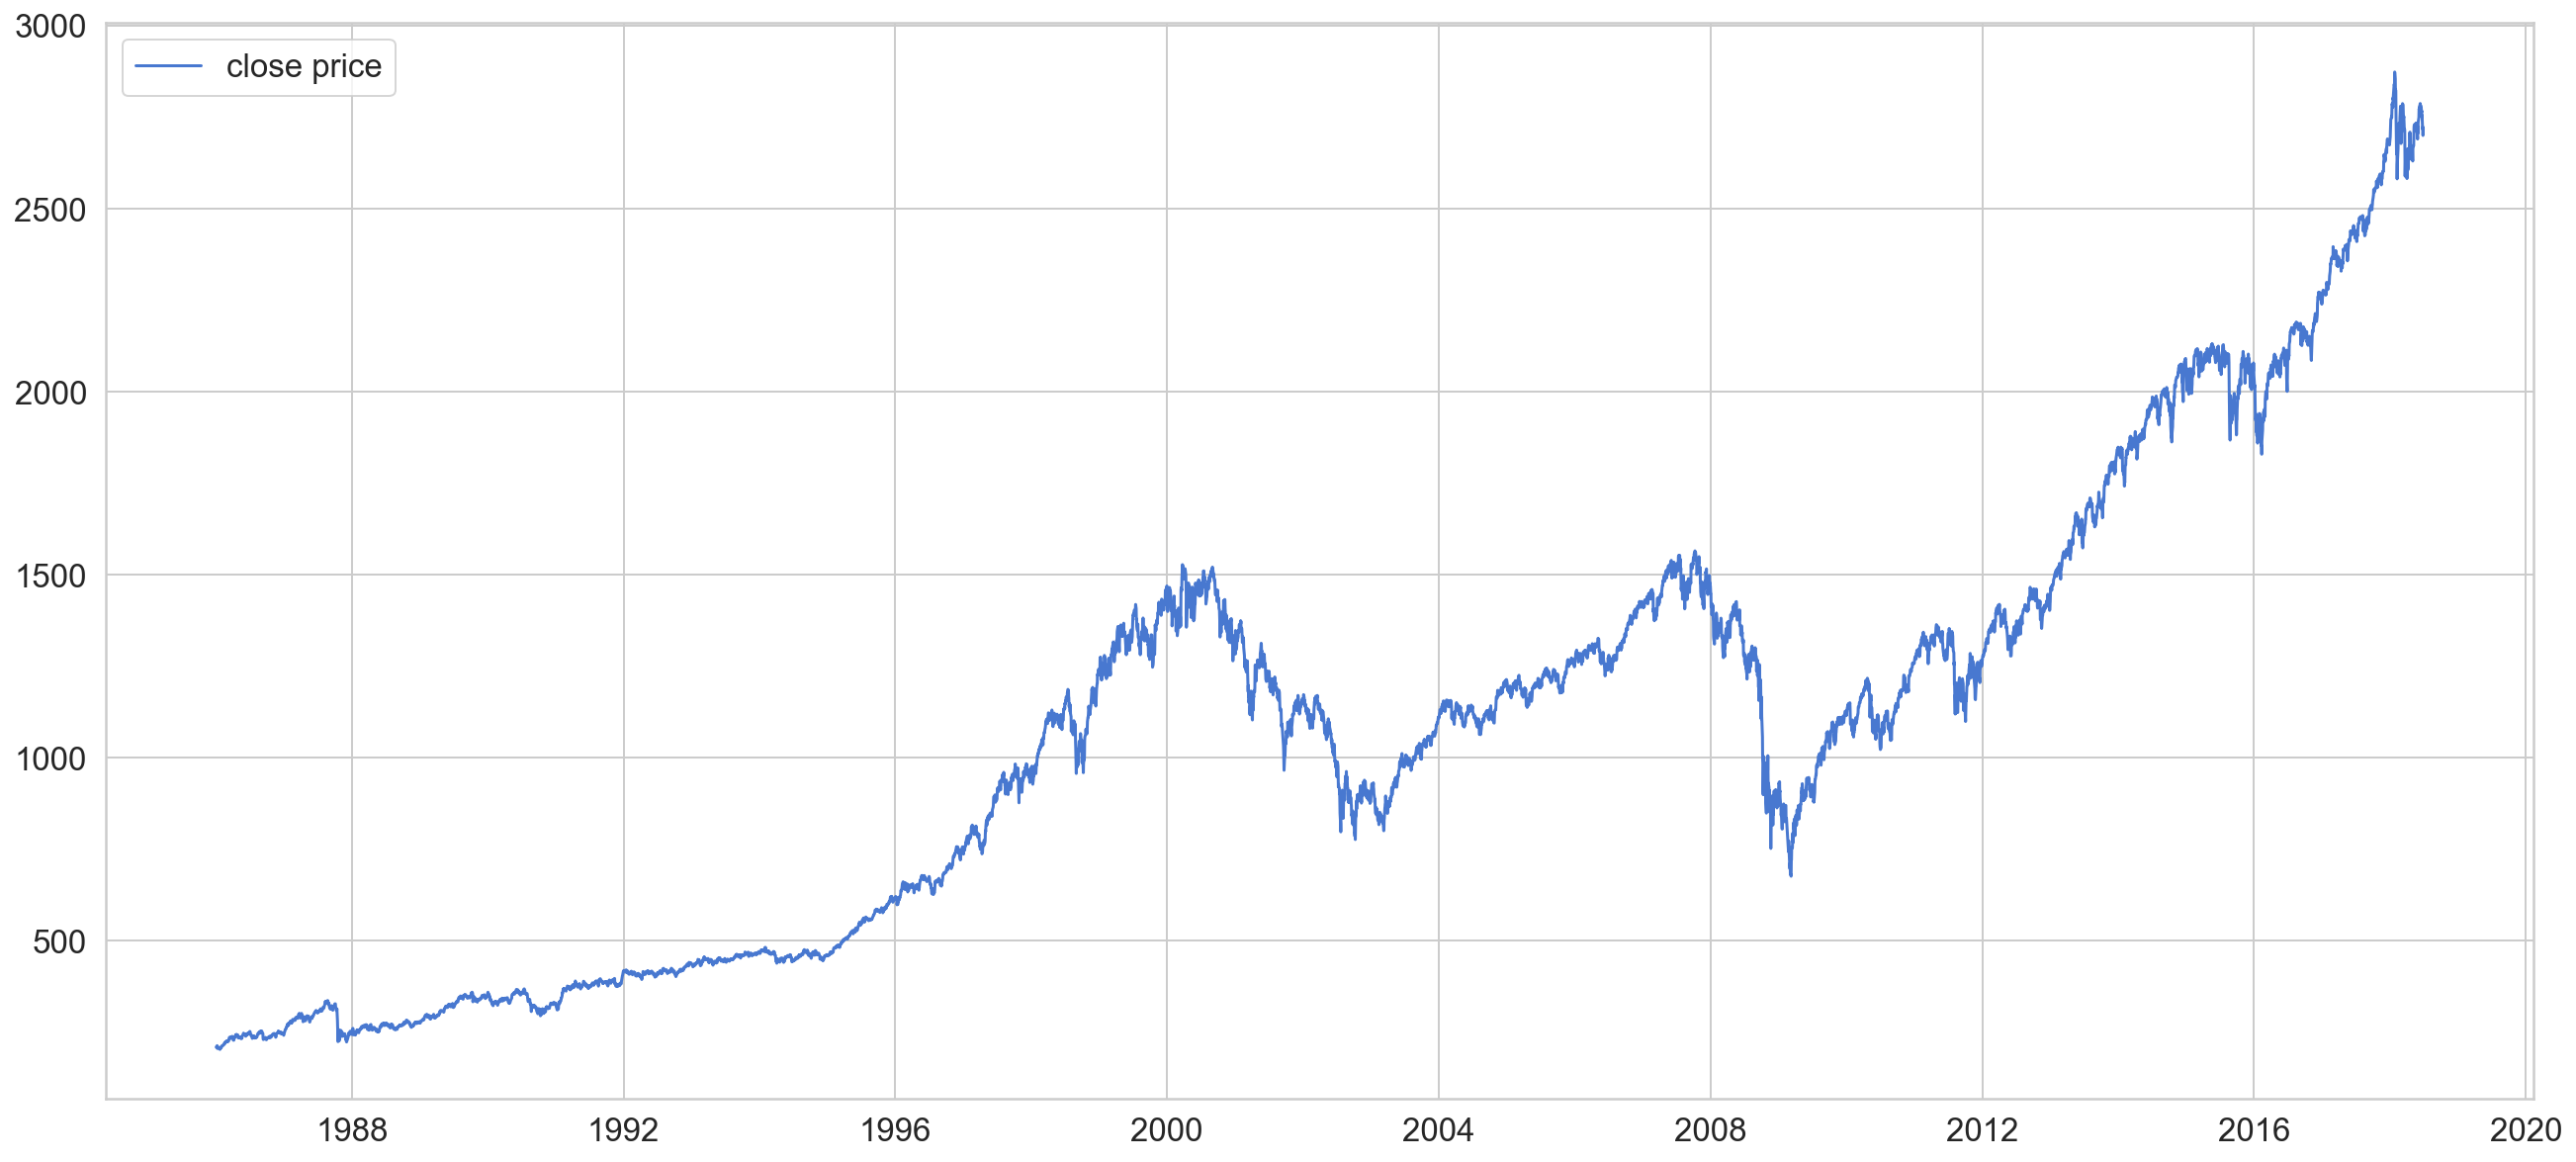

In [13]:
plt.plot(df, label='close price')
plt.legend();

### Preprocessing

We will use 95% of the data for training and 5% for testing:

In [15]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


Now we will rescale the data using the training data and apply the same transformation to the test data.

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Finally, we will split the data into subsequences. To do that, we define a little helper function as follows.

In [21]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

We will create sequences with 30 days worth of historical data

In [22]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


### LSTM Autoencoder in Keras

Our Autoencoder should take a sequence as input and outputs a sequence of the same shape. Here’s how to build such a simple model in Keras.

In [31]:
#----Define the model------

# How the model will be built. 
model = keras.Sequential()

## ~~~~~Encoder Layer~~~~
# input_shape = (TIME_STEPS, NUMBER_OF_FEATURES)
# units = NUMBER_OF_NEURONS aka NUMBER_OF_HIDDEN_STATES
# ref: https://zhuanlan.zhihu.com/p/58854907
model.add(keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))

# RepeatVector allows to Repeat the input n times. 
# RepeatVector repeats the very last output of the encoder.
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

## ~~~~~Decoder Layer~~~~
# return_sequences=True returns all the outputs the encoder observed in the pas
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))

## ~~~~~Prediction Layer~~~~
# TimeDistributed wrapper allows to apply a layer to every temporal slice of an input.
# ref: https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam')

Essentially, return_sequences=True returns all the outputs the encoder observed in the past, while RepeatVector repeats the very last output of the encoder.

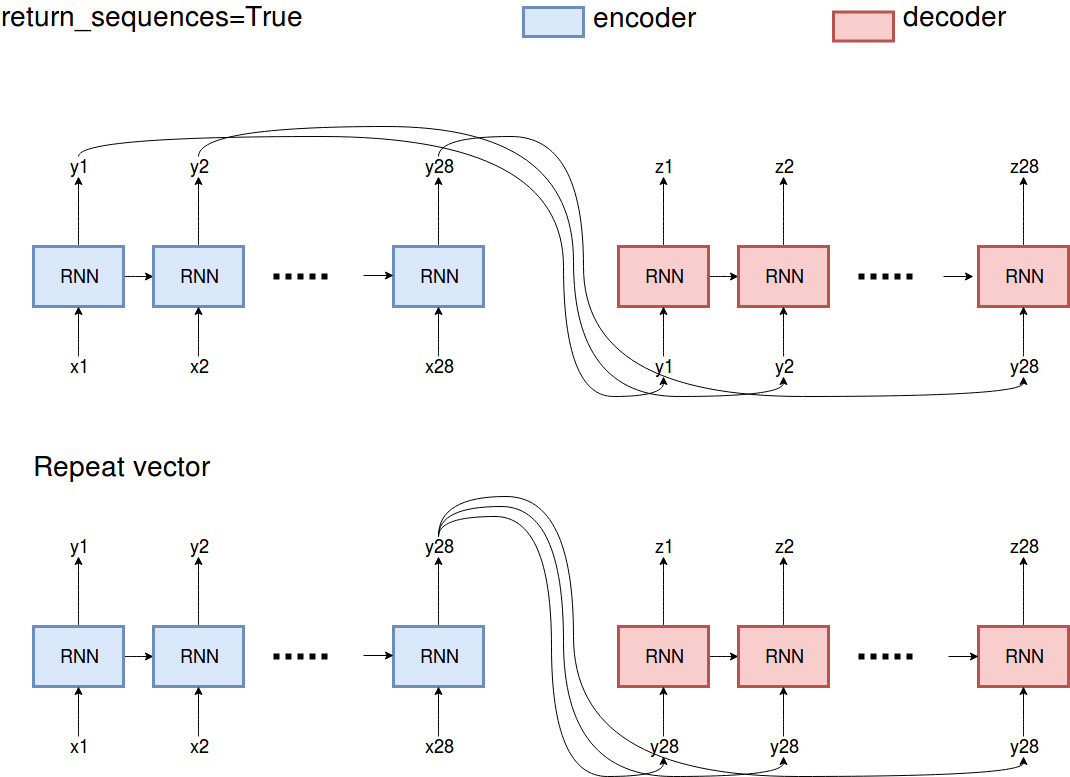


TimeDistributed wrapper allows to apply a layer (e.g. a dense layer) to every temporal stamp of the previous LSTM layer.
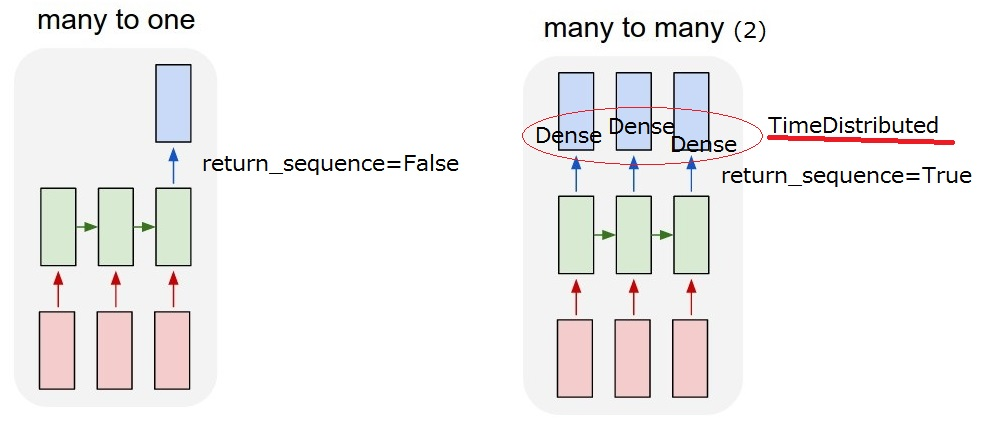

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
____________________________________________________

In [32]:
#-----Fit the model-----------
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 4s 19ms/step - loss: 0.1691 - val_loss: 0.1827
Epoch 2/10
218/218 [==============================] - 4s 16ms/step - loss: 0.0934 - val_loss: 0.1581
Epoch 3/10
218/218 [==============================] - 4s 18ms/step - loss: 0.0964 - val_loss: 0.1302
Epoch 4/10
218/218 [==============================] - 3s 16ms/step - loss: 0.0879 - val_loss: 0.1051
Epoch 5/10
218/218 [==============================] - 3s 16ms/step - loss: 0.0921 - val_loss: 0.0657
Epoch 6/10
218/218 [==============================] - 4s 16ms/step - loss: 0.1050 - val_loss: 0.0976
Epoch 7/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1007 - val_loss: 0.0757
Epoch 8/10
218/218 [==============================] - 3s 16ms/step - loss: 0.1091 - val_loss: 0.0637
Epoch 9/10
218/218 [==============================] - 3s 16ms/step - loss: 0.1034 - val_loss: 0.1188
Epoch 10/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1129 - val_lo

### Evaluation

We have trained our model for 10 epochs with less than 8k examples. Here are the results.

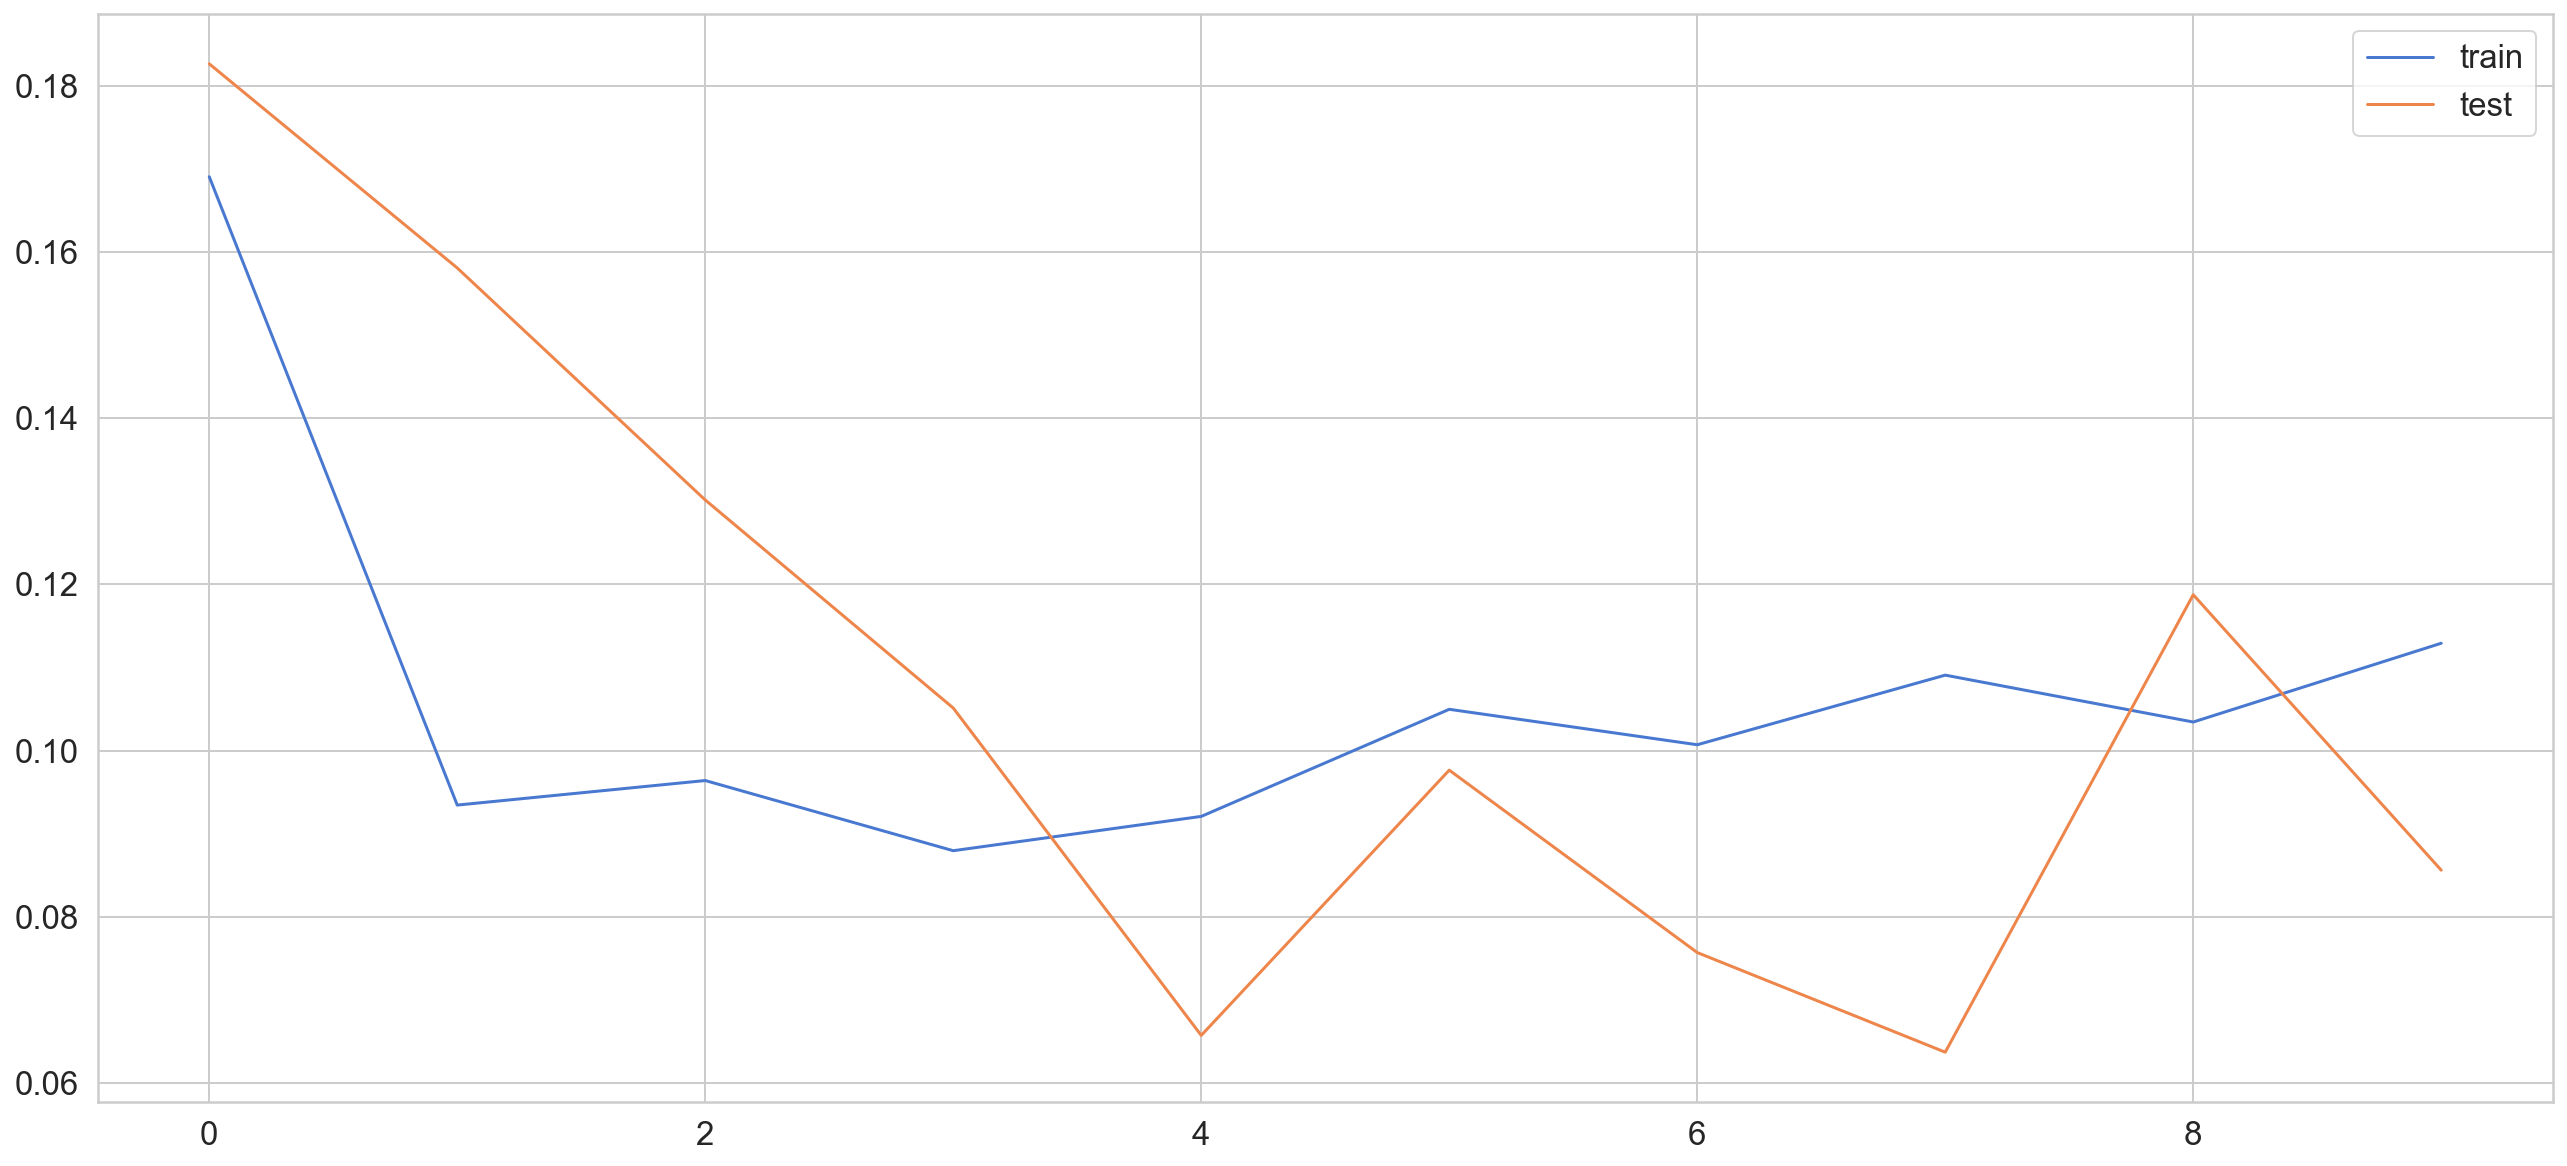

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### Finding Anomalies

Now we prepare to detect anomalies. Let us start with calculating the Mean Absolute Error (MAE) on the training data.

In [35]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

Let us have a look at the error.

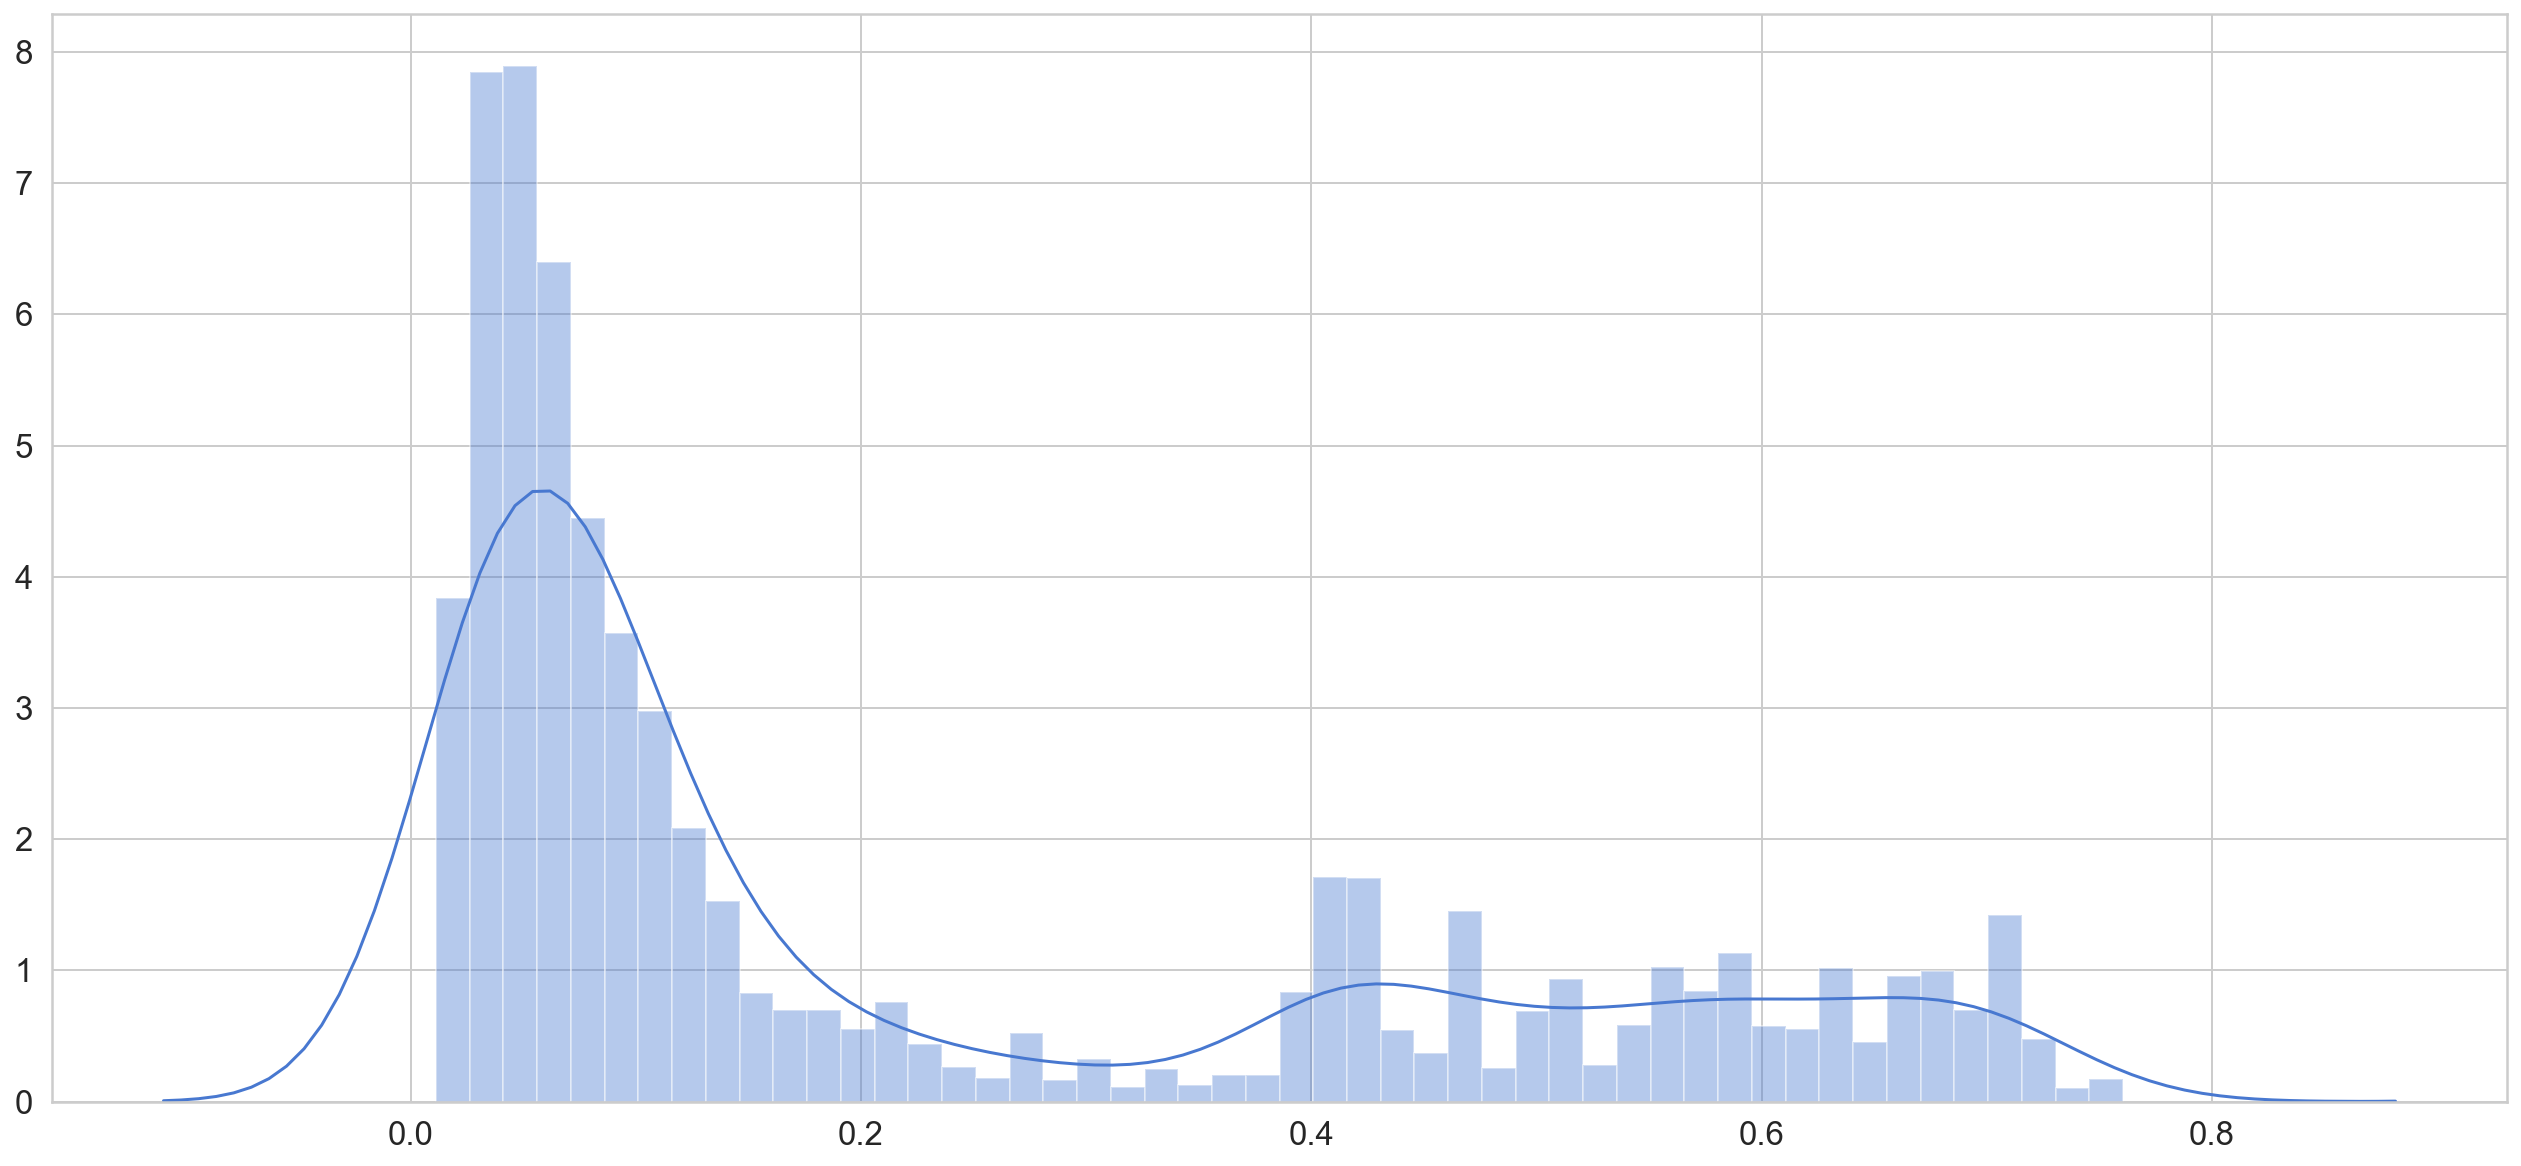

In [36]:
sns.distplot(train_mae_loss, bins=50, kde=True);

#### We wll pick a threshold of 0.4, as not much of the loss is larger than that. When the error is larger than that, we will declare that example an anomaly:

In [44]:
THRESHOLD = 0.4

Let’s calculate the MAE on the test data

In [38]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

We’ll build a DataFrame containing the loss and the anomalies (values above the threshold):

In [45]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

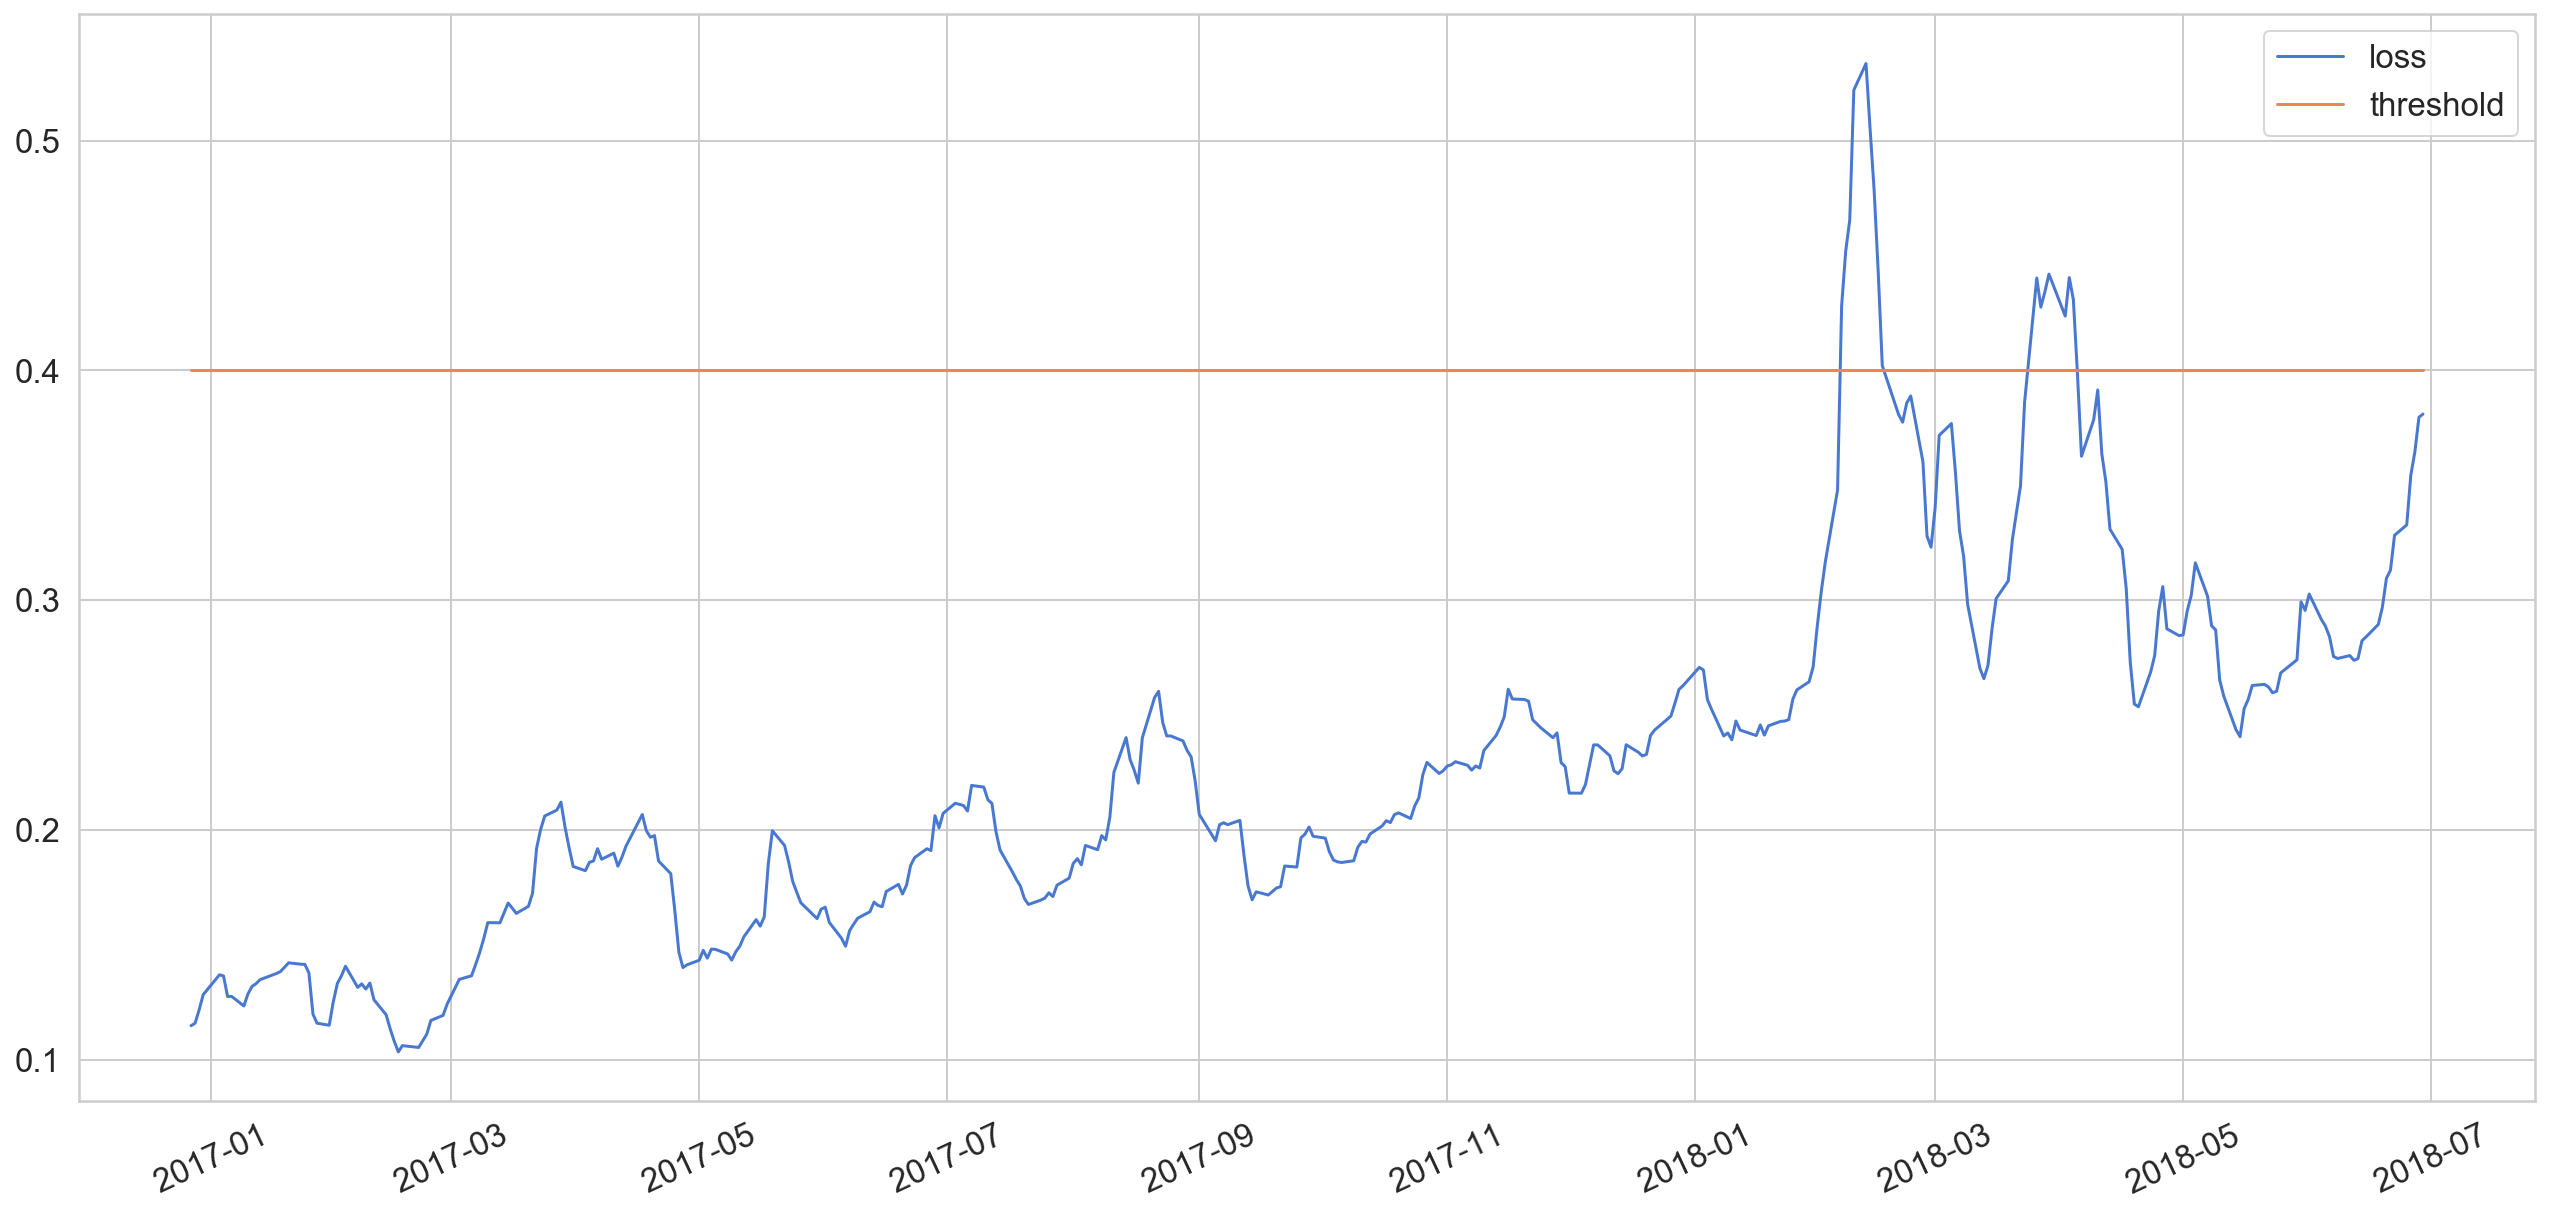

In [46]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

Looks like we’re thresholding extreme values quite well. Let’s create a DataFrame using only those

In [47]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-06,0.427981,0.4,True,3.193456
2018-02-07,0.451784,0.4,True,3.168136
2018-02-08,0.465441,0.4,True,2.979068
2018-02-09,0.521965,0.4,True,3.051476
2018-02-12,0.533532,0.4,True,3.119939


Finally, let’s look at the anomalies found in the testing data:

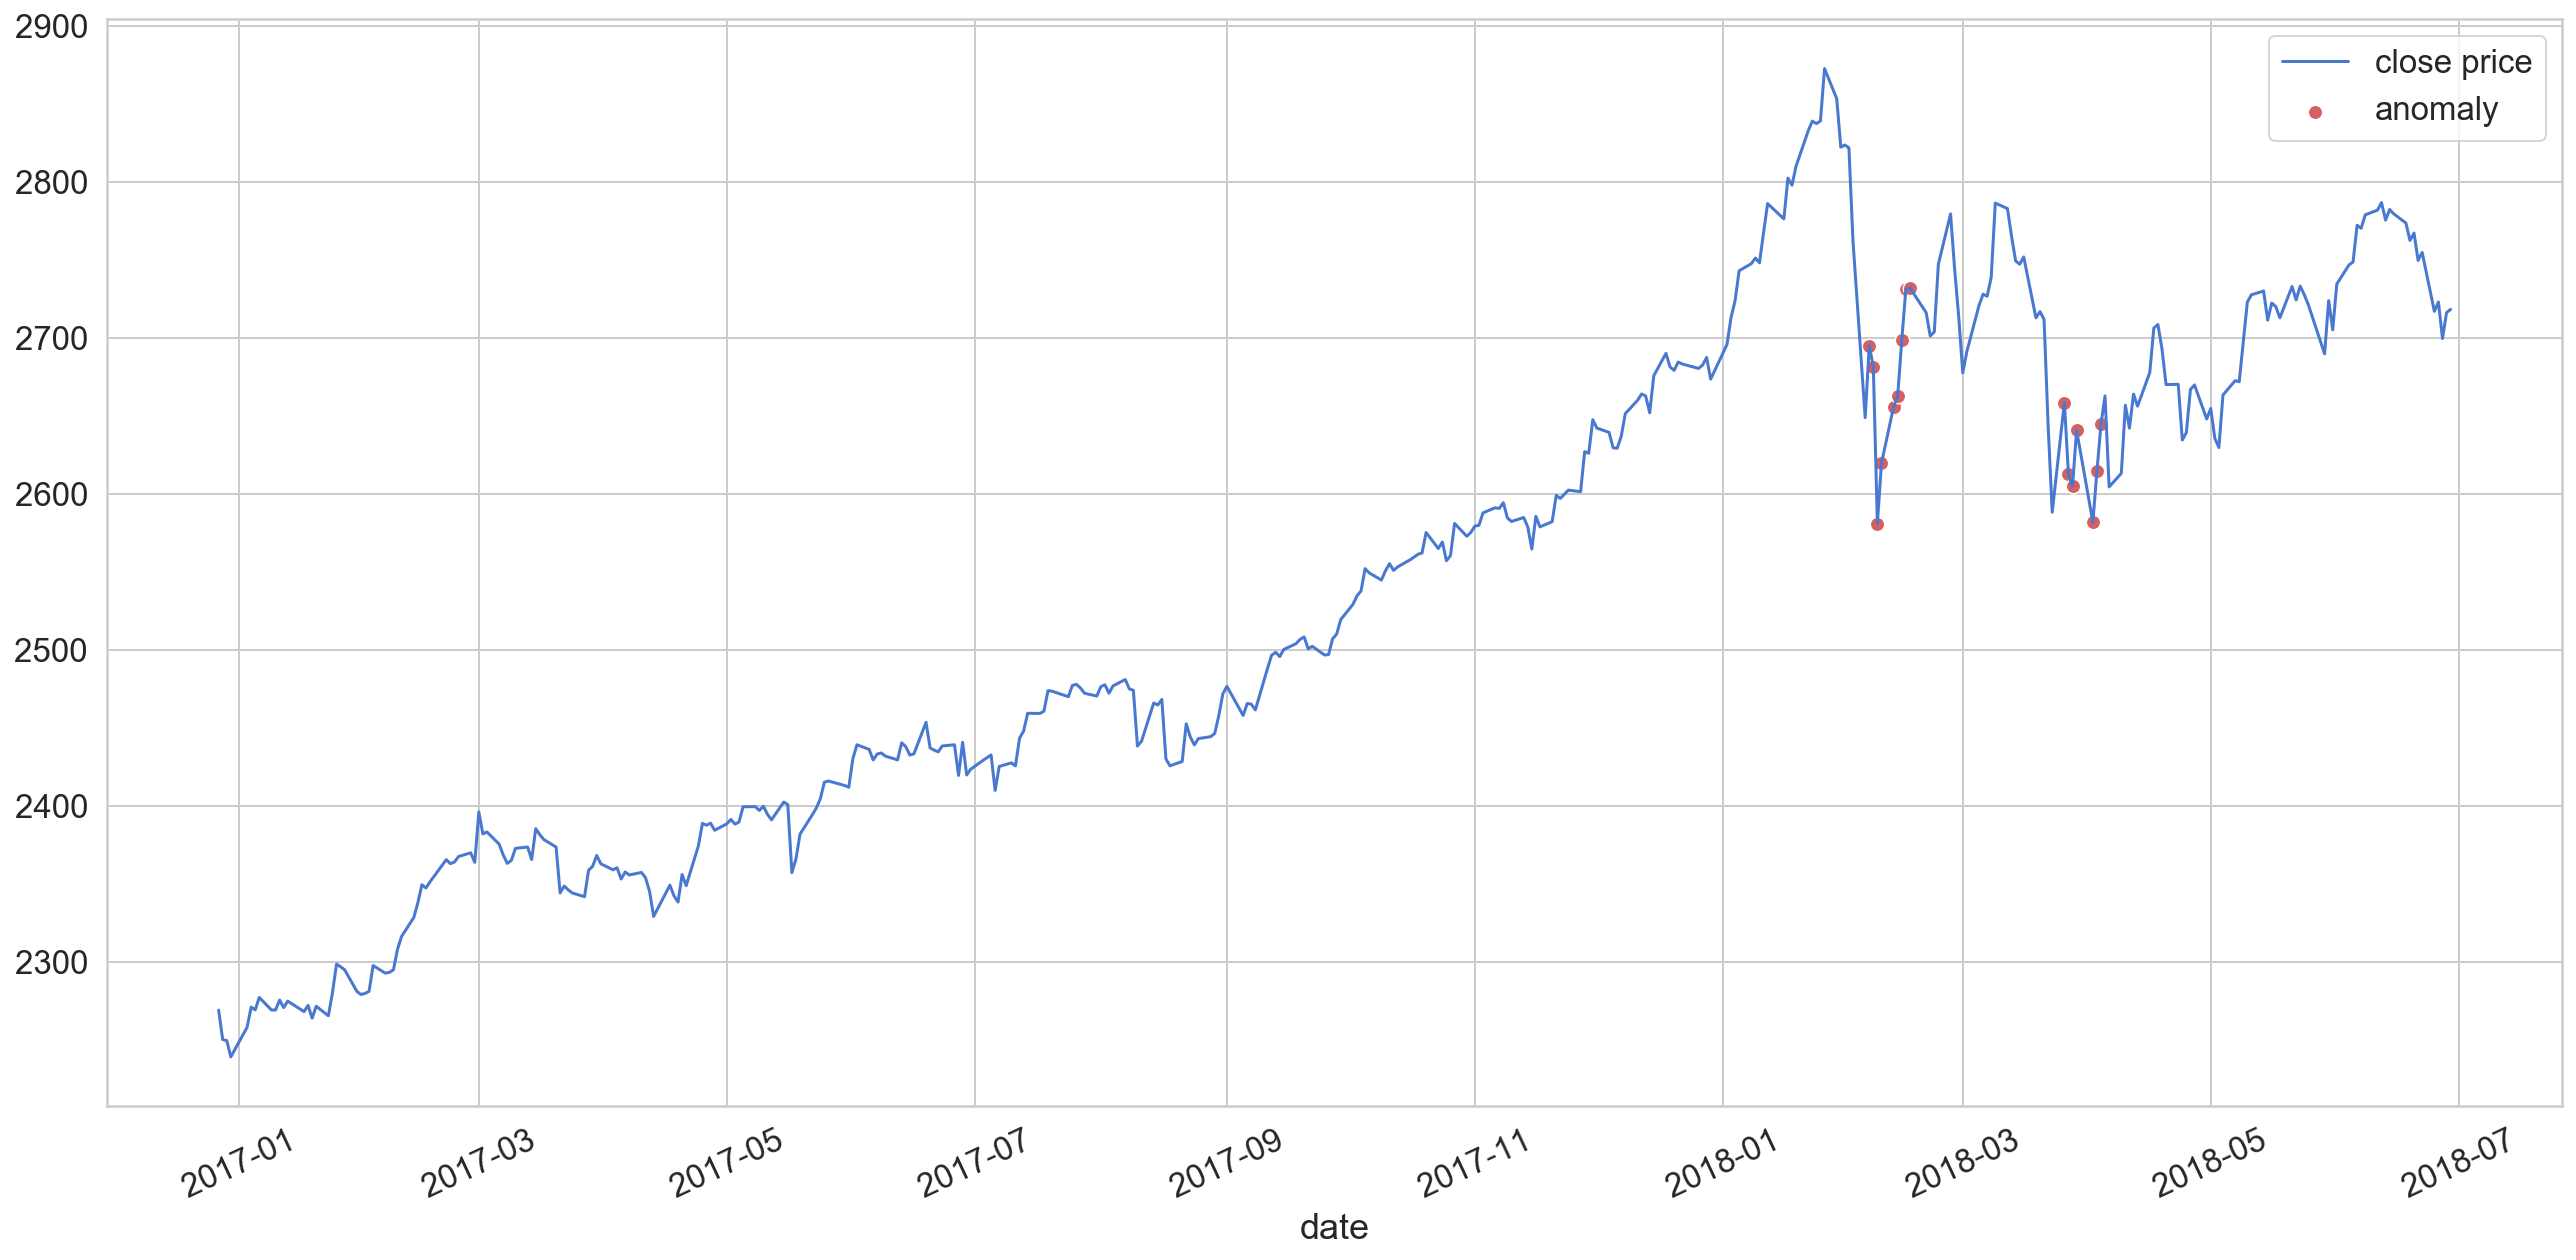

In [48]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();